In [1]:
import os
import torch
import yaml
from pathlib import Path
import random
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import plotly.graph_objects as go
from torch.utils.data import Dataset

from nerfstudio.configs import base_config as cfg
from nerfstudio.configs.method_configs import method_configs
from nerfstudio.data.dataparsers.nerfosr_dataparser import NeRFOSR, NeRFOSRDataParserConfig
from nerfstudio.pipelines.base_pipeline import VanillaDataManager
from nerfstudio.field_components.field_heads import FieldHeadNames
from nerfstudio.cameras.rays import RayBundle, RaySamples, Frustums
from nerfstudio.utils.colormaps import apply_depth_colormap
from nerfstudio.field_components.encodings import SHEncoding, NeRFEncoding
import tinycudann as tcnn

from reni_neus.models.reni_neus_model import RENINeuSFactoModelConfig, RENINeuSFactoModel
from reni_neus.utils.utils import look_at_target, random_points_on_unit_sphere
from reni_neus.data.datamanagers.reni_neus_datamanager import RENINeuSDataManagerConfig, RENINeuSDataManager
from reni_neus.configs.ddf_config import DirectionalDistanceField
from reni_neus.configs.reni_neus_config import RENINeuS
from reni_neus.utils.utils import find_nerfstudio_project_root, rot_z

project_root = find_nerfstudio_project_root(Path(os.getcwd()))
# set current working directory to nerfstudio project root
os.chdir(project_root)

# setup config
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

reni_neus_config = RENINeuS
reni_neus_config.config.pipeline.visibility_ckpt_path = Path('outputs/ddf/ddf/2023-08-31_101658/')
reni_neus_config.config.pipeline.visibility_ckpt_step = 20000
reni_neus_config.config.pipeline.reni_neus_ckpt_path = Path('outputs/reni-neus/reni-neus/2023-08-30_111340/')
reni_neus_config.config.pipeline.reni_neus_ckpt_step = 100000
reni_neus_config.config.pipeline.model.use_visibility = True
reni_neus_config.config.pipeline.model.visibility_threshold = 0.1
reni_neus_config.config.pipeline.model.fit_visibility_field = False


pipeline = reni_neus_config.config.pipeline.setup(device=device, test_mode=test_mode, world_size=world_size, local_rank=local_rank)
datamanager = pipeline.datamanager
model = pipeline.model
model = model.eval()

Setting up training dataset...

Caching all 160 images.

Output()

Setting up evaluation dataset...

Caching all 5 images.

Output()

In [ ]:
ray_bundle, batch = datamanager.fixed_indices_eval_dataloader.get_data_from_image_idx(3)
model.render_illumination_animation(ray_bundle=ray_bundle, 
                                    batch=batch,
                                    num_frames=100,
                                    fps=20.0,
                                    visibility_threshold=0.1,
                                    output_path='outputs/renders',
                                    end_frame=50)

In [2]:
ray_bundle, batch = datamanager.fixed_indices_eval_dataloader.get_data_from_image_idx(3)
model.config.fix_test_illumination_directions = True
model.config.visibility_threshold = 0.01
model.render_rgb = True
model.render_accumulation = True
model.render_depth = True
model.render_normal = False
model.render_albedo = False
model.render_shadow_map = True
model.render_shadow_map_static = True
model.shadow_map_threshold.value = 0.2
model.shadow_map_azimuth.value = 90.0
model.shadow_map_elevation.value = 45.0
rotation = rot_z(torch.tensor(np.deg2rad(90.0).item()))
rotation = rotation.to(device)
outputs = model.get_outputs_for_camera_ray_bundle(ray_bundle, show_progress=True, rotation=rotation)

Output()

In [4]:
if outputs is not None:
    # save to a pt file
    torch.save(outputs, "outputs.pt")
else:
    # load from a pt file
    outputs = torch.load("outputs.pt")

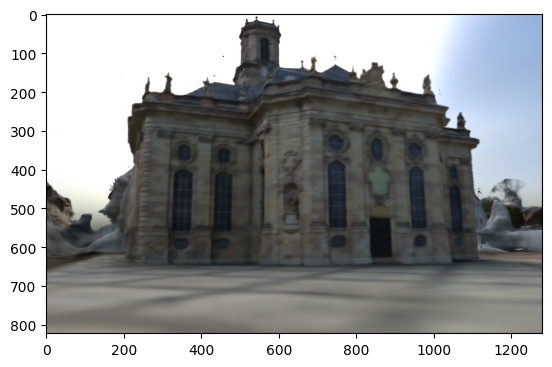

In [3]:
plt.imshow(outputs['rgb'].cpu().detach().numpy())

In [10]:
def compute_visibility(ray_samples, depth, illumination_directions, threshold_distance, accumulation, batch, compute_shadow_map=False):
    """Compute visibility"""
    # ray_samples = [num_rays, num_samples]
    # depth = [num_rays, 1]
    # illumination_directions = [num_rays * num_samples, num_light_directions, xyz]
    # threshold_distance = scalar
    # accumulation = None
    # batch = dict

    # shortcuts for later
    num_rays = ray_samples.frustums.origins.shape[0]
    num_samples = ray_samples.frustums.origins.shape[1]
    original_num_light_directions = illumination_directions.shape[1]

    # illumination_directions = [num_rays * num_samples, num_light_directions, xyz]
    # we only want [num_light_directions, xyz]
    illumination_directions = illumination_directions[0, :, :]

    if model.config.only_upperhemisphere_visibility and not compute_shadow_map:
        # we dot product illumination_directions with the vertical z axis
        # and use it as mask to select only the upper hemisphere
        dot_products = torch.sum(torch.tensor([0, 0, 1]).type_as(illumination_directions) * illumination_directions, dim=1)
        mask = dot_products > 0
        directions = illumination_directions[mask] # [num_light_directions, xyz]
    else:
        directions = illumination_directions
    
    # more shortcuts
    num_light_directions = directions.shape[0]

    # since we are only using a single sample, the sample we think has hit the object,
    # we can just use one of each of these values, they are all just copied for each
    # sample along the ray. So here I'm just taking the first one.
    origins = ray_samples.frustums.origins[:, 0:1, :]  # [num_rays, 1, 3]
    ray_directions = ray_samples.frustums.directions[:, 0:1, :]  # [num_rays, 1, 3]

    # Calculate the new positions
    positions = origins + ray_directions * depth.unsqueeze(1) # [num_rays, 1, 3]

    # check if the new pos are within the sphere
    inside_sphere = positions.norm(dim=-1) < model.ddf_radius # [num_rays, 1]

    # for all positions not inside sphere get sphere intersection points for origins and directions
    # and just subract a small amount from the positions to make sure they are inside the sphere
    positions[~inside_sphere] = model.ray_sphere_intersection(origins[~inside_sphere], ray_directions[~inside_sphere], model.ddf_radius) * 0.01 * -ray_directions[~inside_sphere]
    
    positions = positions.unsqueeze(1).repeat(
        1, num_light_directions, 1, 1
    )  # [num_rays, num_light_directions, 1, 3]
    directions = (
        directions.unsqueeze(0).repeat(num_rays, 1, 1)
    )  # [num_rays, num_light_directions, 1, 3]

    positions = positions.reshape(-1, 3)  # [num_rays * num_light_directions, 3]
    directions = directions.reshape(-1, 3)  # [num_rays * num_light_directions, 3]

    sphere_intersection_points = model.ray_sphere_intersection(positions, directions, model.ddf_radius) # [num_rays * num_light_directions, 3]

    termination_dist = torch.norm(sphere_intersection_points - positions, dim=-1) # [num_rays * num_light_directions]

    # we need directions from intersection points to ray origins
    directions = -directions
    directions = directions / torch.norm(directions, dim=-1, keepdim=True)

    # build a ray_bundle object to pass to the visibility_field
    visibility_ray_bundle = RayBundle(
        origins=sphere_intersection_points,
        directions=directions,
        pixel_area=torch.ones_like(positions[..., 0]), # not used but required for class
        camera_indices=torch.zeros_like(positions[..., 0], dtype=torch.int64),
        metadata={}
    )
    
    ddf_batch = {"termination_dist": termination_dist}
    
    if model.training and batch is not None:
        # we can use the fact that any rays that hit the sky we know
        fg_mask = batch['fg_mask'].detach().clone()
        sky_mask = (1.0 - fg_mask).bool().repeat(1, 3) # [num_sky_rays, 3]

        sky_origins = ray_samples.frustums.origins[:, 0, :][sky_mask].reshape(-1, 3) # [num_sky_rays, 3]
        sky_directions = ray_samples.frustums.directions[:, 0, :][sky_mask].reshape(-1, 3) # [num_sky_rays, 3]
        sky_pixel_ares = torch.ones_like(sky_origins[..., 0]).reshape(-1, 1) # [num_sky_rays, 1]

        sky_ray_bundle = RayBundle(
            origins=sky_origins,
            directions=sky_directions,
            pixel_area=sky_pixel_ares,
        )

        ddf_batch["sky_ray_bundle"] = sky_ray_bundle

    # Get output of visibility field (DDF)
    outputs = model.visibility_field(visibility_ray_bundle, batch=ddf_batch, reni_neus=model) # [N, 2]

    # the ground truth distance from the point on the sphere to the point on the SDF
    dist_to_ray_origins = torch.norm(positions - sphere_intersection_points, dim=-1) # [N]

    # as the DDF can only predict 2*its radius, we need to clamp gt to that
    dist_to_ray_origins = torch.clamp(dist_to_ray_origins, max=model.ddf_radius * 2.0)

    # and get the difference between it and the distance from the point on the sphere to the point on the SDF
    difference = dist_to_ray_origins - outputs["expected_termination_dist"]

    # if the difference is POSITIVE then the point on the SDF is further away than
    # the DDF predicted and so the point is OCCLUDED to illumination from that direction.
    # if the difference is ZERO/NEGATIVE then the point on the SDF is closer than
    # the DDF predicted and so the point is VISIBILE to illumination from that direction.
    # we want to use the sigmoid of the difference as the visibility value
    # and we want to scale so its close to a step function and shift by 'threshold_distance'
    # so be biases towards being visible.
    scale = 50.0
    occlusion = torch.sigmoid(scale * (difference - threshold_distance))
    visibility = 1.0 - occlusion

    if model.config.only_upperhemisphere_visibility and not compute_shadow_map:
        # we now need to use the mask we created earlier to select only the upper hemisphere
        # and then use the predicted visibility values there
        total_vis = torch.ones(num_rays, original_num_light_directions, 1).type_as(visibility)
        # reshape mask to match the total_vis dimensions
        mask = mask.reshape(1, original_num_light_directions, 1).expand_as(total_vis)
        # use the mask to replace the values
        total_vis[mask] = visibility
        visibility = total_vis

    visibility = visibility.unsqueeze(1).repeat(1, num_samples, 1, 1) # [num_rays, num_samples, num_light_directions, 1]
    # and reshape so that it is [num_rays * num_samples, original_num_light_directions, 1]
    visibility = visibility.reshape(-1, original_num_light_directions, 1)

    visibility_dict = outputs
    visibility_dict["visibility"] = visibility
    visibility_dict["expected_termination_dist"] = outputs["expected_termination_dist"]
    visibility_dict["visibility_dict_ray_bundle"] = visibility_ray_bundle
    visibility_dict["sphere_intersection_points"] = sphere_intersection_points
    visibility_dict["positions"] = positions
    visibility_dict["directions"] = directions
    if compute_shadow_map:
        visibility_dict["difference"] = difference
    visibility_dict["visibility_batch"] = {
        "termination_dist": termination_dist,
        "mask": torch.ones_like(termination_dist),
    }
    
    return visibility_dict

In [12]:
def get_output_of_ddf(position):
    c2w = look_at_target(camera_positions=position, target_positions=torch.zeros_like(position))[..., :3, :4]  # (3, 4)
    camera = datamanager.train_dataset.cameras[0]
    camera.camera_to_worlds = c2w.type_as(camera.camera_to_worlds)
    camera_ray_bundle = camera.generate_rays(0)
    H, W = camera_ray_bundle.origins.shape[:2]
    positions = position.unsqueeze(0).repeat(H, W, 1)  # [H, W, 3]
    directions = camera_ray_bundle.directions  # [H, W, 3]
    pixel_area = camera_ray_bundle.pixel_area  # [H, W, 1]

    ray_bundle = RayBundle(
        origins=positions.to(model.visibility_field.device),
        directions=directions.to(model.visibility_field.device),
        pixel_area=torch.ones_like(pixel_area).to(model.visibility_field.device),
        camera_indices=torch.zeros_like(pixel_area).to(model.visibility_field.device),
        metadata={},
    )

    output = model.visibility_field.get_outputs_for_camera_ray_bundle(camera_ray_bundle=ray_bundle, reni_neus=None, show_progress=True)
    return output, positions, directions

In [14]:
depth = outputs['p2p_dist'] # [H, W, 1]
origins = ray_bundle.origins # [H, W, 3]
directions = ray_bundle.directions # [H, W, 3]
positions = ray_bundle.origins + ray_bundle.directions * depth

origins = origins.reshape(-1, 3)
directions = directions.reshape(-1, 3)
positions = positions.reshape(-1, 3)
depth = depth.reshape(-1, 1)

# choose a random set of N points
N = 1000
idx = np.random.choice(positions.shape[0], N, replace=False)

origins = origins[idx]
directions = directions[idx]
positions = positions[idx]
depth = depth[idx]

# we need to be in num_rays, num_samples, 3
origins = origins.unsqueeze(1)
directions = directions.unsqueeze(1)
positions = positions.unsqueeze(1)

ray_samples = RaySamples(frustums=Frustums(origins=origins, directions=directions, starts=torch.zeros_like(origins), ends=torch.ones_like(origins), pixel_area=torch.ones_like(origins)),
                         camera_indices=torch.zeros_like(origins, dtype=torch.int64) * 3,
)

# choose an illumination direction
azimuth = -90.0
elevation = 45.0
azimuth = azimuth * np.pi / 180
elevation = elevation * np.pi / 180
ddf_sample_direction = torch.tensor([np.cos(azimuth) * np.cos(elevation),
                                      np.sin(azimuth) * np.cos(elevation),
                                      np.sin(elevation)]).to(model.device)
ddf_sample_direction = ddf_sample_direction.unsqueeze(0).unsqueeze(0) # Shape: [1, 1, 3]
ddf_sample_direction = ddf_sample_direction.repeat(ray_samples.shape[0], 1, 1) # Shape: [num_rays, 1, 3]
ddf_sample_direction = ddf_sample_direction.type_as(origins)

# illumination_directions = [num_rays * num_samples, num_light_directions, xyz]
visibility_dict = compute_visibility(ray_samples=ray_samples, # [num_rays, num_samples] [N, 1]
                                    depth=depth, # [num_rays, 1]
                                    illumination_directions=ddf_sample_direction, # [num_rays * num_samples, num_directions, 3] [N*1, 1, 3]
                                    threshold_distance=0.3,
                                    accumulation=None,
                                    batch=None,
                                    compute_shadow_map=True)

ddf_positions = visibility_dict['visibility_dict_ray_bundle'].origins # [N, 3]
ddf_directions = visibility_dict['visibility_dict_ray_bundle'].directions # [N, 3]
ddf_depth = visibility_dict['expected_termination_dist'].unsqueeze(-1) # [N, 1]
ddf_term_positions = ddf_positions + ddf_directions * ddf_depth # [N, 3]

# positions = positions.squeeze(1).cpu().detach().numpy()
positions = visibility_dict['positions'].cpu().detach().numpy()
x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]

ddf_term_positions = ddf_term_positions.cpu().detach().numpy()
i, j, k = ddf_term_positions[:, 0], ddf_term_positions[:, 1], ddf_term_positions[:, 2]

# get output of ddf for inward facing camera on sphere
position = ray_bundle.origins[0, 0].unsqueeze(0) # [1, 3]
# add some value to z and then normalise
position[0, 2] = position[0, 2] + 0.5
position = position / torch.norm(position)

ddf_camera_output, positions, directions = get_output_of_ddf(position)
ddf_camera_term_positions = positions + directions.type_as(positions) * ddf_camera_output['expected_termination_dist'].type_as(positions)
ddf_camera_term_positions = ddf_camera_term_positions.reshape(-1, 3)
ddf_camera_term_positions = ddf_camera_term_positions[idx]
ddf_camera_term_positions = ddf_camera_term_positions.cpu().detach().numpy()
l, m, n = ddf_camera_term_positions[:, 0], ddf_camera_term_positions[:, 1], ddf_camera_term_positions[:, 2]


sphere_intersection_points = visibility_dict['sphere_intersection_points'].cpu().detach().numpy() # [N, 3]
p, q, r = sphere_intersection_points[:, 0], sphere_intersection_points[:, 1], sphere_intersection_points[:, 2]

# add position scatter coloured blue
fig = go.Figure(data=[go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(size=2,
                color='blue')
)])

# add ddf termination points coloured red
fig.add_trace(go.Scatter3d(
    x=i, y=j, z=k,
    mode='markers',
    marker=dict(size=2,
                color='red')
))

# add sphere intersection points coloured yellow
fig.add_trace(go.Scatter3d(
    x=p, y=q, z=r,
    mode='markers',
    marker=dict(size=2,
                color='yellow')
))

# Set aspect ratio and bounds
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-1.0, 1.0]),
        yaxis=dict(range=[-1.0, 1.0]),
        zaxis=dict(range=[-1.0, 1.0]),
        aspectmode='cube'  # this sets equal aspect ratio
    ),
    autosize=False,
    width=800,  # set the width of the plot in pixels
    height=800,  # set the height of the plot in pixels
)

fig.show()

Output()

In [1]:
depth = outputs['depth'] # [H, W, 1]
origins = ray_bundle.origins # [H, W, 3]
directions = ray_bundle.directions # [H, W, 3]
positions = ray_bundle.origins + ray_bundle.directions * depth

origins = origins.reshape(-1, 3)
directions = directions.reshape(-1, 3)
positions = positions.reshape(-1, 3)
depth = depth.reshape(-1, 1)

# choose a random set of N points
N = 1000
idx = np.random.choice(positions.shape[0], N, replace=False)

origins = origins[idx]
directions = directions[idx]
positions = positions[idx]
depth = depth[idx]

# we need to be in num_rays, num_samples, 3
origins = origins.unsqueeze(1)
directions = directions.unsqueeze(1)
positions = positions.unsqueeze(1)

ray_samples = RaySamples(frustums=Frustums(origins=origins, directions=directions, starts=torch.zeros_like(origins), ends=torch.ones_like(origins), pixel_area=torch.ones_like(origins)),
                         camera_indices=torch.zeros_like(origins, dtype=torch.int64) * 3,
)

# choose an illumination direction
azimuth = -90.0
elevation = 45.0
azimuth = azimuth * np.pi / 180
elevation = elevation * np.pi / 180
ddf_sample_direction = torch.tensor([np.cos(azimuth) * np.cos(elevation),
                                      np.sin(azimuth) * np.cos(elevation),
                                      np.sin(elevation)]).to(model.device)
ddf_sample_direction = ddf_sample_direction.unsqueeze(0).unsqueeze(0) # Shape: [1, 1, 3]
ddf_sample_direction = ddf_sample_direction.repeat(ray_samples.shape[0], 1, 1) # Shape: [num_rays, 1, 3]
ddf_sample_direction = ddf_sample_direction.type_as(origins)

# illumination_directions = [num_rays * num_samples, num_light_directions, xyz]
visibility_dict = compute_visibility(ray_samples=ray_samples, # [num_rays, num_samples] [N, 1]
                                    depth=depth, # [num_rays, 1]
                                    illumination_directions=ddf_sample_direction, # [num_rays * num_samples, num_directions, 3] [N*1, 1, 3]
                                    threshold_distance=0.3,
                                    accumulation=None,
                                    batch=None,
                                    compute_shadow_map=True)

ddf_positions = visibility_dict['visibility_dict_ray_bundle'].origins # [N, 3]
ddf_directions = visibility_dict['visibility_dict_ray_bundle'].directions # [N, 3]
ddf_depth = visibility_dict['expected_termination_dist'].unsqueeze(-1) # [N, 1]
ddf_term_positions = ddf_positions + ddf_directions * ddf_depth # [N, 3]

# positions = positions.squeeze(1).cpu().detach().numpy()
positions = visibility_dict['positions'].cpu().detach().numpy()
x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]

ddf_term_positions = ddf_term_positions.cpu().detach().numpy()
i, j, k = ddf_term_positions[:, 0], ddf_term_positions[:, 1], ddf_term_positions[:, 2]

# get output of ddf for inward facing camera on sphere
position = ray_bundle.origins[0, 0].unsqueeze(0) # [1, 3]
# add some value to z and then normalise
position[0, 2] = position[0, 2] + 0.5
position = position / torch.norm(position)

ddf_camera_output, positions, directions = get_output_of_ddf(position)
ddf_camera_term_positions = positions + directions.type_as(positions) * ddf_camera_output['expected_termination_dist'].type_as(positions)
ddf_camera_term_positions = ddf_camera_term_positions.reshape(-1, 3)
ddf_camera_term_positions = ddf_camera_term_positions[idx]
ddf_camera_term_positions = ddf_camera_term_positions.cpu().detach().numpy()
l, m, n = ddf_camera_term_positions[:, 0], ddf_camera_term_positions[:, 1], ddf_camera_term_positions[:, 2]


sphere_intersection_points = visibility_dict['sphere_intersection_points'].cpu().detach().numpy() # [N, 3]
p, q, r = sphere_intersection_points[:, 0], sphere_intersection_points[:, 1], sphere_intersection_points[:, 2]

# add position scatter coloured blue
fig = go.Figure(data=[go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(size=2,
                color='blue')
)])

# add ddf termination points coloured red
fig.add_trace(go.Scatter3d(
    x=i, y=j, z=k,
    mode='markers',
    marker=dict(size=2,
                color='red')
))

# add sphere intersection points coloured yellow
fig.add_trace(go.Scatter3d(
    x=p, y=q, z=r,
    mode='markers',
    marker=dict(size=2,
                color='yellow')
))

# Set aspect ratio and bounds
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-1.0, 1.0]),
        yaxis=dict(range=[-1.0, 1.0]),
        zaxis=dict(range=[-1.0, 1.0]),
        aspectmode='cube'  # this sets equal aspect ratio
    ),
    autosize=False,
    width=800,  # set the width of the plot in pixels
    height=800,  # set the height of the plot in pixels
)

fig.show()

NameError: name 'outputs' is not defined